# TP Nº1 - Alumna: Lara Rosenberg

# TinyGPT



Basandonos en los códigos creados por el profesor Abraham R, debemos realizar las siguientes tareas:
- Usando la función generadora de texto, implementar la decodificación greedy y los muestreos top k, top n y aplicar temperatura.
- Usando TinyGPT, convertirlo en un *Mixture of Experts* (MoE) con al menos 2 expertos.

### ¿Qué esperar?

- Comprender en profundidad la implementación de un modelo GPT.
- Implementar una capa MoE para crear un modelo GPT de vanguardia.
- Explorar algoritmos de decodificación para generación de texto.

In [1]:
# Importamos las librerias necesarias
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

## Descargando el conjunto de datos

In [2]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Codificación basada en caracteres

In [3]:
chars = sorted(list(set(text))) #lista de caracteres (incluso trae las letras en mayuscula y minuscula)
vocab_size = len(chars) #61
stoi = {ch: i for i, ch in enumerate(chars)} #diccionario donde las llaves son los caracteres y los valores una enumeracion del 0 al 60
itos = {i: ch for ch, i in stoi.items()} #diccionario invertido
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)

# División base de entrenamiento/prueba
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

# Cargadores de datos

In [4]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# Configuración de GPT

In [5]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe_args : Optional[MoEArgs] = None
    #moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 8, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 61, 'bias': True, 'ff_class': None, 'moe_args': None}


In [6]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8,
                        )

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

# Proyección QKV combinada
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

# Atención de producto punto escalado
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [9]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## Arquitectura de TinyGPT

In [10]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits

## Función de generación (inferencia)

In [11]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

# Configuración

In [12]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
model = torch.compile(m)

In [13]:
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

# Entrenamiento

In [14]:
# Instancia del Trainer
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Entrenamiento
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Época {epoch+1} - pérdida de entrenamiento: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Época {epoch+1} - pérdida de validación: {val_loss:.4f}")

print("Entrenamiento completo.")

  0%|          | 0/11246 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
W0812 18:16:45.732000 1319 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_indu

Época 1 - pérdida de entrenamiento: 2.2201


  0%|          | 0/1246 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val_loss 2.08976: 100%|██████████| 1246/1246 [00:10<00:00, 118.25it/s]


Época 1 - pérdida de validación: 2.0635


loss 2.15957: 100%|██████████| 11246/11246 [03:31<00:00, 53.27it/s]


Época 2 - pérdida de entrenamiento: 2.1430


val_loss 2.08975: 100%|██████████| 1246/1246 [00:09<00:00, 126.51it/s]

Época 2 - pérdida de validación: 2.0635
Entrenamiento completo.


### Prueba rápida

In [15]:
generate("To be", max_new_tokens=100,use_cache=True)

"To bear, thean. I be you dere, mand\nWeroid wow unal'd ale.\n\nCOMIOLARICINIUS:\nThim hin andizers. Peqere ad"

Como podemos observar, el modelo no logra completar la oración "To be" con algo coherente. Incluso inventa la mayoria de palabras.

# Tarea I

Usando TinyGPT debes implementar las siguientes modificaciones:


## Inferencia: modifica la función `generate` para:
- Decodificación *greedy* (seleccionar el token con mayor probabilidad).
- Muestreo por temperatura.
- Muestreo *top‑k* o *top‑p*.

### Referencias
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)


## Partimos de algunas definiciones

La **temperatura** ajusta la distribución de probabilidad de los tokens antes de que se aplique la estrategia de muestreo (como top-k o top-p).
* T < 1	--> la respuesta es más conservadora (menos aleatoria), ya que le da mas peso a los token más probables.

* T = 1	--> Neutra.	Usa la distribución tal como la predice el modelo.
* T > 1 --> Más creativo y diverso, pero más propenso a errores o incoherencias.



Cuando un modelo de lenguaje predice la siguiente palabra o token, asigna una probabilidad a cada posible opción. En lugar de elegir siempre la palabra con mayor probabilidad (lo que puede producir texto repetitivo o poco creativo), el modelo puede usar "**top-k** sampling" para hacer la elección más variada.

Top-k significa que el modelo:

1. Ordena todas las posibles palabras siguientes según su probabilidad.

2. Toma las k más probables.

3. Elige aleatoriamente una palabra solo entre esas k opciones, de acuerdo con sus probabilidades normalizadas.

Otra opcion es hacer "**top-n**": en lugar de un número fijo de tokens (k), selecciona el conjunto más pequeño de palabras cuya probabilidad acumulada supera un umbral p

In [16]:
@torch.no_grad()
def generateV2(
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: int = 10,
    top_p: float = 0.9,
    greedy: bool = False
):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        # Contexto de entrada
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        logits = logits[:, -1, :] / temperature  # aplicamos la temperatura
        probs = F.softmax(logits, dim=-1)

        if greedy:
            next_token = torch.argmax(probs, dim=-1, keepdim=True)

        else:
            # Muestreo top-k
            if top_k is not None:
              values, indices = torch.topk(probs, top_k)
              probs_new = torch.zeros_like(probs).scatter(1, indices, values)
              probs = probs_new / probs_new.sum(dim=-1, keepdim=True)

            # Muestreo top-p
            if top_p is not None:
              sorted_probs, sorted_indices = torch.sort(probs, descending=True)
              cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
              cutoff = cumulative_probs > top_p

              # Apagamos todo después del primer valor que exceda top_p
              cutoff[..., 1:] = cutoff[..., :-1].clone()
              cutoff[..., 0] = 0
              sorted_probs[cutoff] = 0.0

              # Reconstruimos la distribución original
              probs = torch.zeros_like(probs).scatter(1, sorted_indices, sorted_probs)
              probs = probs / probs.sum(dim=-1, keepdim=True)

            next_token = torch.multinomial(probs, num_samples=1)

        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

## Comparamos las salidas de `generate` vs `generateV2`

In [17]:
print('Generate')
print(generate("To be", max_new_tokens=100,use_cache=True))
print('-----------------------------------------------------')
print('Generate V2')
print(generateV2("To be", max_new_tokens=100,use_cache=True))
print('-----------------------------------------------------')
print('Generate V2 - Greedy')
print(generateV2("To be", max_new_tokens=100,use_cache=True, greedy= True))
print('-----------------------------------------------------')
print('Generate V2 - Con temperatura > 1')
print(generateV2("To be", max_new_tokens=100,use_cache=True, temperature= 1.5))
print('-----------------------------------------------------')
print('Generate V2 - Con temperatura < 1')
print(generateV2("To be", max_new_tokens=100,use_cache=True, temperature= 0.75))
print('-----------------------------------------------------')
print('Generate V2 - Con top k 10')
print(generateV2("To be", max_new_tokens=100,use_cache=True, top_k= 10))
print('-----------------------------------------------------')
print('Generate V2 - Con top k 5 + temperatura < 1')
print(generateV2("To be", max_new_tokens=100,use_cache=True, top_k= 5 , temperature= 0.85))
print('-----------------------------------------------------')
print('Generate V2 - Con top k 15 + temperatura < 1')
print(generateV2("To be", max_new_tokens=100,use_cache=True, top_k= 15 , temperature= 0.85))
print('-----------------------------------------------------')
print('Generate V2 - Con top p 0.90')
print(generateV2("To be", max_new_tokens=100,use_cache=True, top_p= 0.90))
print('-----------------------------------------------------')
print('Generate V2 - Con top p 0.70 + temperatura < 1')
print(generateV2("To be", max_new_tokens=100,use_cache=True, top_p= 0.70 ,temperature= 0.85))
print('-----------------------------------------------------')
print('Generate V2 - Con top p 0.95 + temperatura < 1')
print(generateV2("To be", max_new_tokens=100,use_cache=True, top_p= 0.95 , temperature= 0.85))
print('-----------------------------------------------------')

Generate
To bey medavencively.itsonde, thest ge prove we your ange:
Youl'dit, the deseove you sw.

We to Bedace!


-----------------------------------------------------
Generate V2
To be the thay aver matirst store.

Maten mome therase to whaland thit ther are thigall he shard
What ass
-----------------------------------------------------
Generate V2 - Greedy
To beand the the the the the the the the the the the the the the the the the the the the the the the the 
-----------------------------------------------------
Generate V2 - Con temperatura > 1
To bere ham.

SINIUS:
MARA:
He bus tine hirow ons,
He wints hat st athenes, wid, oft must mas ithes.
Nall
-----------------------------------------------------
Generate V2 - Con temperatura < 1
To bered, bat our wore the hit
Be the whow ist are the and ast so an are the and and the sut are the to m
-----------------------------------------------------
Generate V2 - Con top k 10
To bere beares wad hen theatry ant of has he we he at sis.

MEN

Como podemos observar, cuando aplicamos greedy, el modelo siempre repite la misma palabra ("the").
Al aplicar temperatura > 1 vemos que el modelo inventa más palabras que cuando aplicamos una temperatura < 1.
No se observa una diferencia significativa al aplicar top k y aumentar el k considerado para el muestreo y lo mismo sucede al aplicar top p.

## Tarea II
- Convierte TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

Para esta implementación, la idea es utilizar un Sparse MoE, donde nos quedaremos únicamente con el top k de expertos (num_experts_per_token) para cada token.
Mas adelante, dejo también una implementación de un Dense MoE, donde utiliza a todos los expertos y pondera las salidas de cada uno (lo cual es más ineficiente a nivel computacional)

In [18]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self,config:GPTConfig) -> None:
        """
        Initiates expert MLP given dimensions/hidden dimensions.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        ) ## Example network

    def forward(self, x) -> torch.Tensor:
        #return None
        return self.net(x)

# La clase Gate es esencial para decidir qué expertos activar. Esta red toma las entradas y calcula un puntaje para cada experto.
class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe_args.num_experts)

    def forward(self, x):
        return self.proj(x)


In [19]:
#La clase MoELayer es el núcleo de nuestro MoE. Toma las salidas de la clase Gate, selecciona los expertos apropiados y luego combina sus salidas.
class MoELayer(nn.Module):
    def __init__(self, experts: List[nn.Module], gate: nn.Module, moe_args: MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, C) donde C = n_embd
        """
        B, T, C = x.shape
        x_flat = x.view(-1, C)

        # Obtenemos los logits de cada experto y aplicamos la función softmax para obtener pesos
        gate_logits = self.gate(x_flat)

        topk_weights, topk_indices = torch.topk(
            gate_logits, k=self.args.num_experts_per_token, dim=-1
        )  # topk_indices: qué expertos se seleccionaron, topk_weights: qué tan fuerte es la activación para cada uno

        topk_weights = torch.softmax(topk_weights, dim=-1)  # normalizamos los pesos, para que sumen 1 por token

        # Salida final para cada token
        output = torch.zeros_like(x_flat)  # salida vacía

        for i in range(self.args.num_experts_per_token):
            expert_idx = topk_indices[:, i]  # (B*T,)
            expert_weight = topk_weights[:, i].unsqueeze(1)  # (B*T, 1)

            # Creamos una máscara binaria para cada experto
            for expert_id, expert in enumerate(self.experts):
                mask = (expert_idx == expert_id)  # (B*T,)
                if mask.sum() == 0:
                    continue

                selected_input = x_flat[mask]  # (N_selected, C)
                expert_output = expert(selected_input)  # (N_selected, C)
                weighted_output = expert_output * expert_weight[mask]  # (N_selected, C)

                output[mask] += weighted_output

        return output.view(B, T, C)  # Volvemos a shape original

In [20]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.moe = MoELayer(
            experts=[Expert(config) for _ in range(config.moe_args.num_experts)],
            gate=Gate(config),
            moe_args=config.moe_args
        )

    def forward(self, x):
        return self.moe(x)

## Añadiendo MoE a la configuración

In [21]:
config.ff_class = MoEFFN
config.moe_args = MoEArgs(num_experts=4, num_experts_per_token=2)

# Entrenamiento de TinyGPT‑MoE

In [22]:
m_moe = TinyGPT(config).to(device)
model_moe = torch.compile(m_moe)

In [23]:
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

In [24]:
# Instancia del Trainer
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Entrenamiento
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Época {epoch+1} - pérdida de entrenamiento: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Época {epoch+1} - pérdida de validación: {val_loss:.4f}")

print("Entrenamiento completo.")

  0%|          | 0/11246 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
loss 2.09685: 100%|██████████| 11246/11246 [10:01<00:00, 18.70it/s]


Época 1 - pérdida de entrenamiento: 2.0756


  0%|          | 0/1246 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val_loss 2.00224: 100%|██████████| 1246/1246 [00:24<00:00, 51.58it/s]


Época 1 - pérdida de validación: 2.0134


  0%|          | 0/11246 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
loss 2.05165: 100%|██████████| 11246/11246 [10:04<00:00, 18.60it/s]


Época 2 - pérdida de entrenamiento: 2.0832


val_loss 2.00224: 100%|██████████| 1246/1246 [00:24<00:00, 50.01it/s]

Época 2 - pérdida de validación: 2.0134
Entrenamiento completo.


In [25]:
# Imprimimos el modelo para ver su arquitectura
print(model_moe)

OptimizedModule(
  (_orig_mod): TinyGPT(
    (token_emb): Embedding(61, 64)
    (pos_emb): Embedding(32, 64)
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): MultiHeadAttention(
          (heads): ModuleList(
            (0-3): 4 x AttentionHead(
              (key_query_value): Linear(in_features=64, out_features=48, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (proj): Linear(in_features=64, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): MoEFFN(
          (moe): MoELayer(
            (experts): ModuleList(
              (0-3): 4 x Expert(
                (net): Sequential(
                  (0): Linear(in_features=64, out_features=256, bias=True)
                  (1): ReLU()
                  (2): Linear(in_features=256, o

### Evaluamos los resultados

In [26]:
@torch.no_grad()
def generateV2(
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: int = 10,
    top_p: float = 0.9,
    greedy: bool = False
):
    model_moe.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        # Contexto de entrada
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model_moe(idx_cond, kv_cache=kv_cache) if use_cache else model_moe(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        logits = logits[:, -1, :] / temperature  # aplicar temperatura
        probs = F.softmax(logits, dim=-1)

        # Muestreo top-k
        if top_k is not None:
            values, indices = torch.topk(probs, top_k)
            probs_new = torch.zeros_like(probs).scatter_(1, indices, values)
            probs = probs_new / probs_new.sum(dim=-1, keepdim=True)

        # Muestreo top-p
        if top_p is not None:
            sorted_probs, sorted_indices = torch.sort(probs, descending=True)
            cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
            cutoff = cumulative_probs > top_p

            # Apagamos todo después del primer valor que exceda top_p
            cutoff[..., 1:] = cutoff[..., :-1].clone()
            cutoff[..., 0] = 0
            sorted_probs[cutoff] = 0.0


            probs = torch.zeros_like(probs).scatter_(1, sorted_indices, sorted_probs)
            probs = probs / probs.sum(dim=-1, keepdim=True)

        if greedy:
            next_token = torch.argmax(probs, dim=-1, keepdim=True)
        else:
            next_token = torch.multinomial(probs, num_samples=1)

        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

Realizamos las mismas consultas para comparar esta implementación vs la implementación sin MoE

In [28]:
print('Generate V2')
print(generateV2("To be", max_new_tokens=100,use_cache=True))
print('-----------------------------------------------------')
print('Generate V2 - Greedy')
print(generateV2("To be", max_new_tokens=100,use_cache=True, greedy= True))
print('-----------------------------------------------------')
print('Generate V2 - Con temperatura > 1')
print(generateV2("To be", max_new_tokens=100,use_cache=True, temperature= 1.5))
print('-----------------------------------------------------')
print('Generate V2 - Con temperatura < 1')
print(generateV2("To be", max_new_tokens=100,use_cache=True, temperature= 0.75))
print('-----------------------------------------------------')
print('Generate V2 - Con top k 10')
print(generateV2("To be", max_new_tokens=100,use_cache=True, top_k= 10))
print('-----------------------------------------------------')
print('Generate V2 - Con top k 5 + temperatura < 1')
print(generateV2("To be", max_new_tokens=100,use_cache=True, top_k= 5 , temperature= 0.85))
print('-----------------------------------------------------')
print('Generate V2 - Con top k 15 + temperatura < 1')
print(generateV2("To be", max_new_tokens=100,use_cache=True, top_k= 15 , temperature= 0.85))
print('-----------------------------------------------------')
print('Generate V2 - Con top p 0.90')
print(generateV2("To be", max_new_tokens=100,use_cache=True, top_p= 0.90))
print('-----------------------------------------------------')
print('Generate V2 - Con top p 0.70 + temperatura < 1')
print(generateV2("To be", max_new_tokens=100,use_cache=True, top_p= 0.70 ,temperature= 0.85))
print('-----------------------------------------------------')
print('Generate V2 - Con top p 0.95 + temperatura < 1')
print(generateV2("To be", max_new_tokens=100,use_cache=True, top_p= 0.95 , temperature= 0.85))
print('-----------------------------------------------------')

Generate V2
To benowe his and he thenear that thame ant it beall to theered such ine as our haly, aver sthan the stin
-----------------------------------------------------
Generate V2 - Greedy
To be the the the the the the the the the the the the the the the the the the the the the the the the the
-----------------------------------------------------
Generate V2 - Con temperatura > 1
To beat,
Ta whemengren wass whin med hins
We seale thas stenetro shess them mols ougelven he put idy: a b
-----------------------------------------------------
Generate V2 - Con temperatura < 1
To be shitis,
That and my we whar mem and it the me the theis will heall she theim the call his are mars 
-----------------------------------------------------
Generate V2 - Con top k 10
To beat in he he wand muthing he shid my thory mald shis be witer theith hall and spelate se wast hith at
-----------------------------------------------------
Generate V2 - Con top k 5 + temperatura < 1
To beale the wen he hathath 

### Dense MoE

In [ ]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self,config:GPTConfig) -> None:
        """
        Initiates expert MLP given dimensions/hidden dimensions.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        ) ## Example network

    def forward(self, x) -> torch.Tensor:
        #return None
        return self.net(x)

# La clase Gate es esencial para decidir qué expertos activar. Esta red toma las entradas y calcula un puntaje para cada experto.
class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe_args.num_experts)

    def forward(self, x):
        return self.proj(x)

# En esta implementación, todos los expertos aportan.
class MoELayer(nn.Module):
    """
    Mixture of experts FeedForward Layer
    """

    def __init__(self, experts : List[nn.Module], gate : nn.Module, moe_args : MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x : torch.Tensor) -> torch.Tensor:

        """
        Ejecuta los expertos seleccionados y combina sus salidas.
        """
        B, T, C = x.shape  # Forma: [batch_size, seq_len, emb_size]

        # 1. Obtenemos los puntajes de la gate
        gate_scores = self.gate(x)

        # 2. Aplicamos softmax a los puntajes para obtener probabilidades
        gate_probs = F.softmax(gate_scores, dim=-1)

        # 3. Calculamos la salida ponderada de los expertos
        expert_outputs = []
        for i, expert in enumerate(self.experts):
            expert_output = expert(x)
            expert_outputs.append(expert_output)

        # Convertimos la lista de salidas de expertos en un tensor [B, T, num_experts, emb_size]
        expert_outputs = torch.stack(expert_outputs, dim=-2)

        # 4. Ponderamos la salida de cada experto por su puntaje
        weighted_outputs = torch.sum(expert_outputs * gate_probs.unsqueeze(-1), dim=-2)

        return weighted_outputs

class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.moe = MoELayer(
            experts=[Expert(config) for _ in range(config.moe_args.num_experts)],
            gate=Gate(config),
            moe_args=config.moe_args
        )

    def forward(self, x):
        return self.moe(x)

## Visualización de la atención

Como sabemos, un GPT tiene la tarea de completar texto; veamos los mapas de atención generados por un modelo preentrenado

In [ ]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

# Ejecutar forward con return_weights=True
    logits, all_weights = model(idx, return_weights=True)

# all_weights es una lista de longitud n_layers
# cada elemento: shape (n_heads, batch_size, seq_len, seq_len)
# Solo visualizaremos el primer elemento del batch

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()

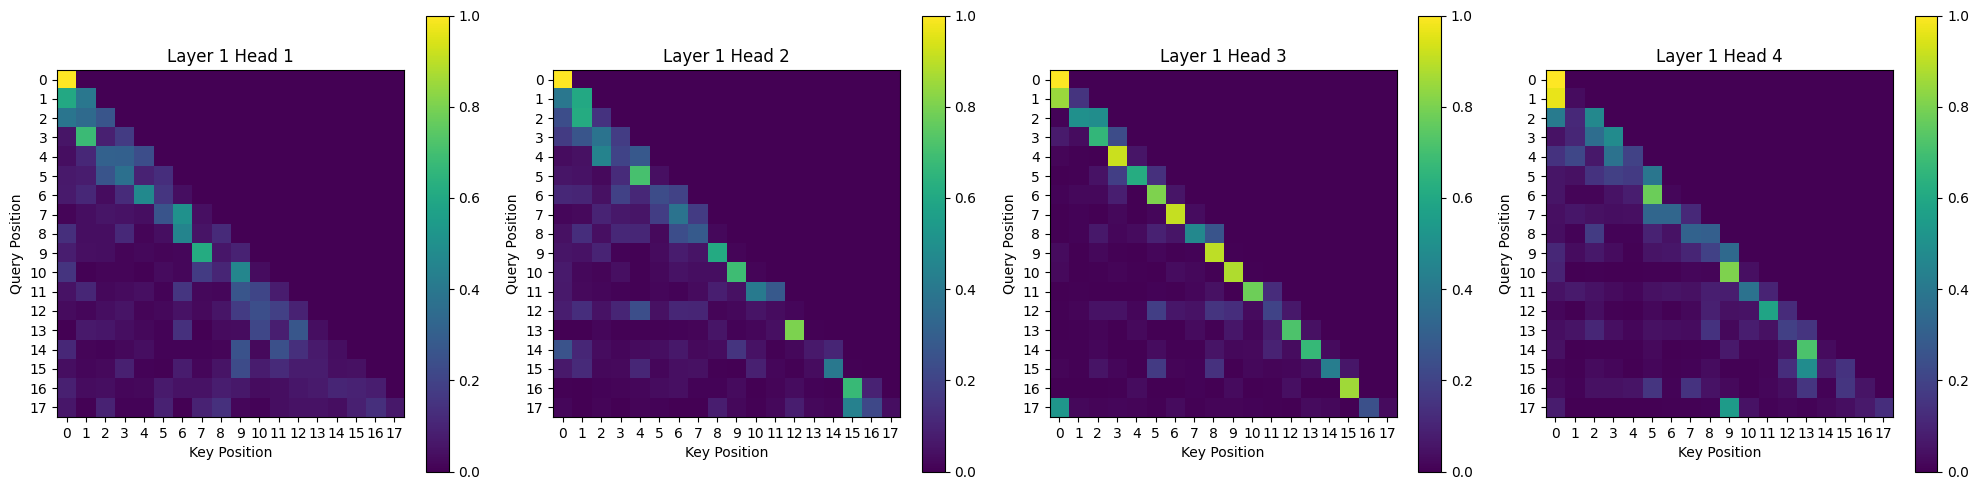

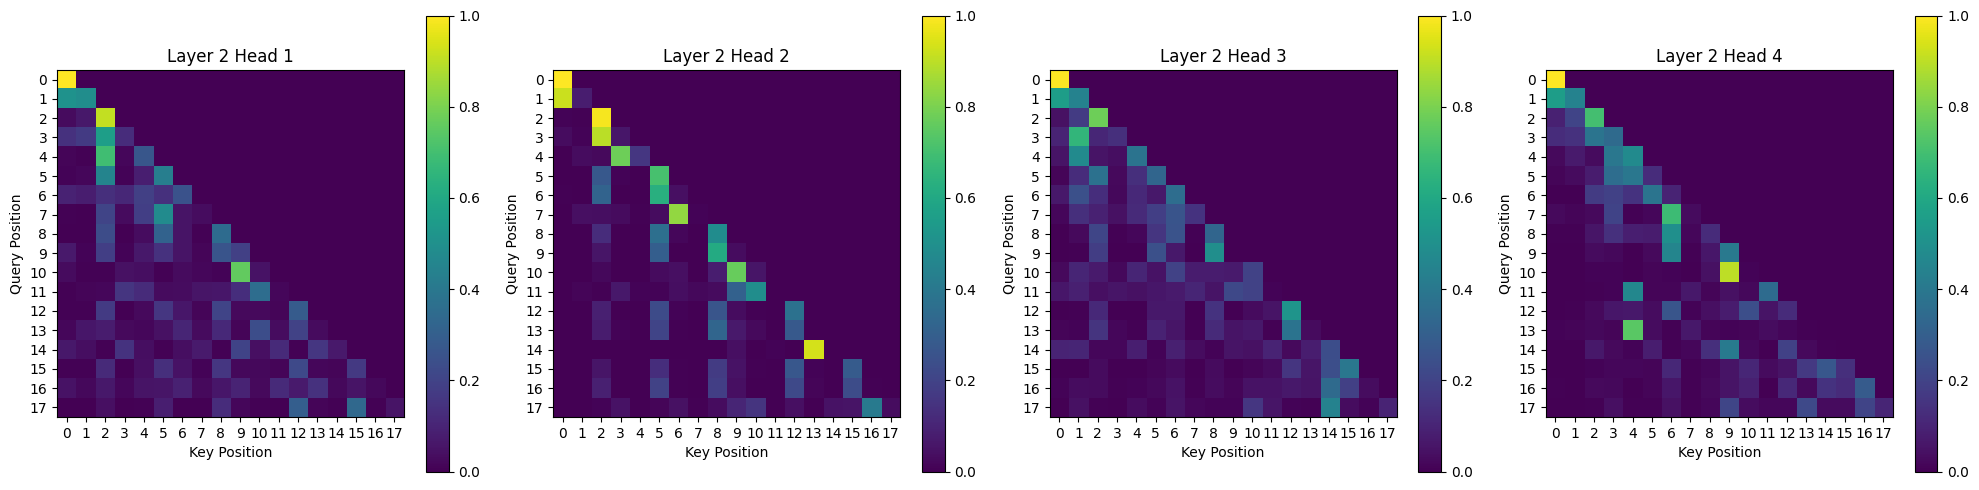

In [ ]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

# Conclusiones

- En la primera versión (sin MoE) observamos que los textos que se generaban sobre la oración to be eran muy incoherentes (muchas palabras nisiquiera existen). Los ajustes de temperatura, muestreos por top-n y top-k no lograron mejorar sustancialmente el contenido que se generaba. Si activabamos la eleccion de token greedy, veíamos que el texto repetia siempre la misma palabra: "the".
- Al incorporar MoE, vemos que el modelo funciona un poco mejor, pero sigue sin llegar a formar un texto coherente. Lo que podemos notar es que al menos redujo la cantidad de palabras inventadas que no tienen ningun significado.
- Con respecto a la visualización de la atención, vemos que hay casos con layers y heads donde la atención es dispersa, lo cual puede sugerir que el modelo está tratando de aprender relaciones globales en la secuencia (ej:layer 1 head 1). Tambien vemos casos donde la atención es más concentrada en ciertas posiciones, lo que podría indicar que el modelo está enfocándose principalmente en ciertas partes de la secuencia (por ejemplo, layer 1 head 3).
